# **Data Collection**

In [1]:
import pandas as pd

In [2]:
movies=pd.read_csv('movies.csv')
ratings=pd.read_csv('ratings.csv')
tags=pd.read_csv('tags.csv')

In [3]:
print(movies.head())
print(ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


# **Data Preprocessing**

In [4]:
print(movies.isnull().sum())
print(ratings.isnull().sum())

print("Duplicate rows in movies:", movies.duplicated().sum())
print("Duplicate rows in ratings:", ratings.duplicated().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Duplicate rows in movies: 0
Duplicate rows in ratings: 0


In [5]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['genres'] = movies['genres'].str.split('|')

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# **Exploratory Data Analysis (EDA)**

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

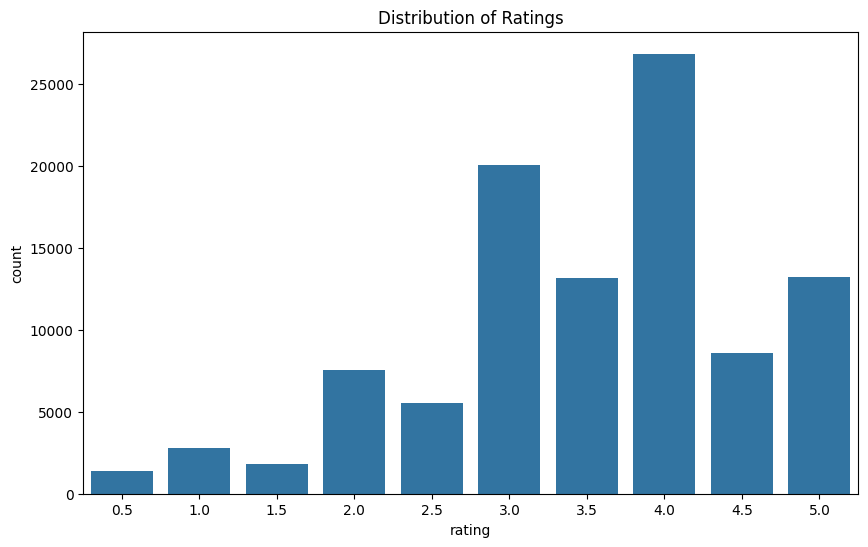

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

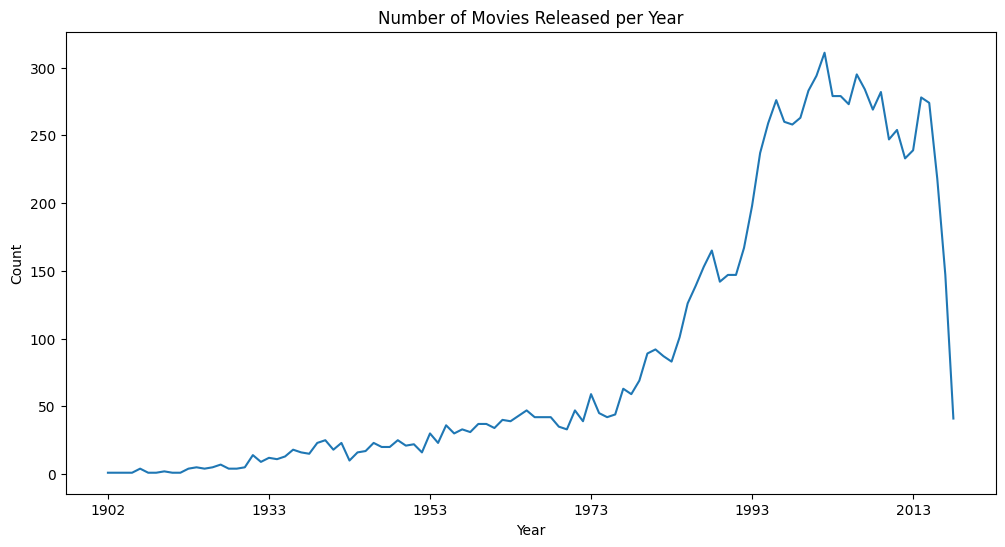

In [8]:
plt.figure(figsize=(12, 6))
movies['year'].value_counts().sort_index().plot(kind='line')
plt.title("Number of Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

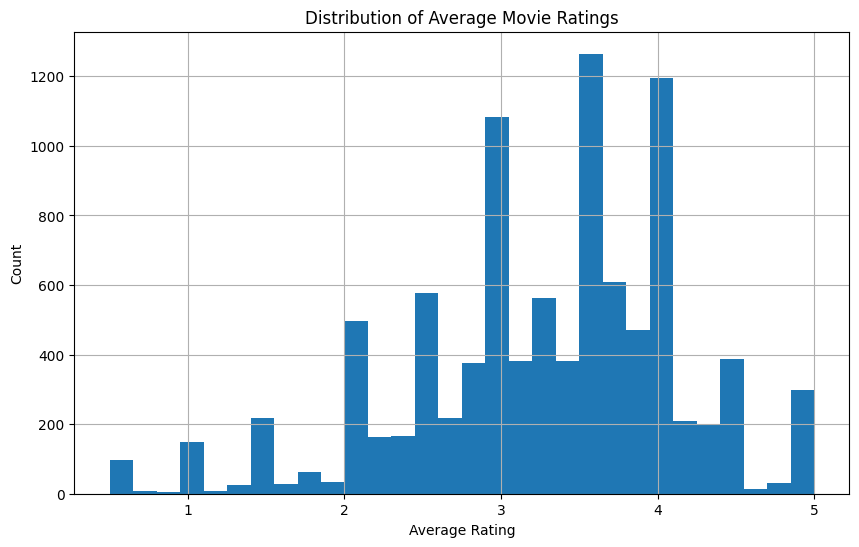

In [9]:
avg_ratings = ratings.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 6))
avg_ratings.hist(bins=30)
plt.title('Distribution of Average Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

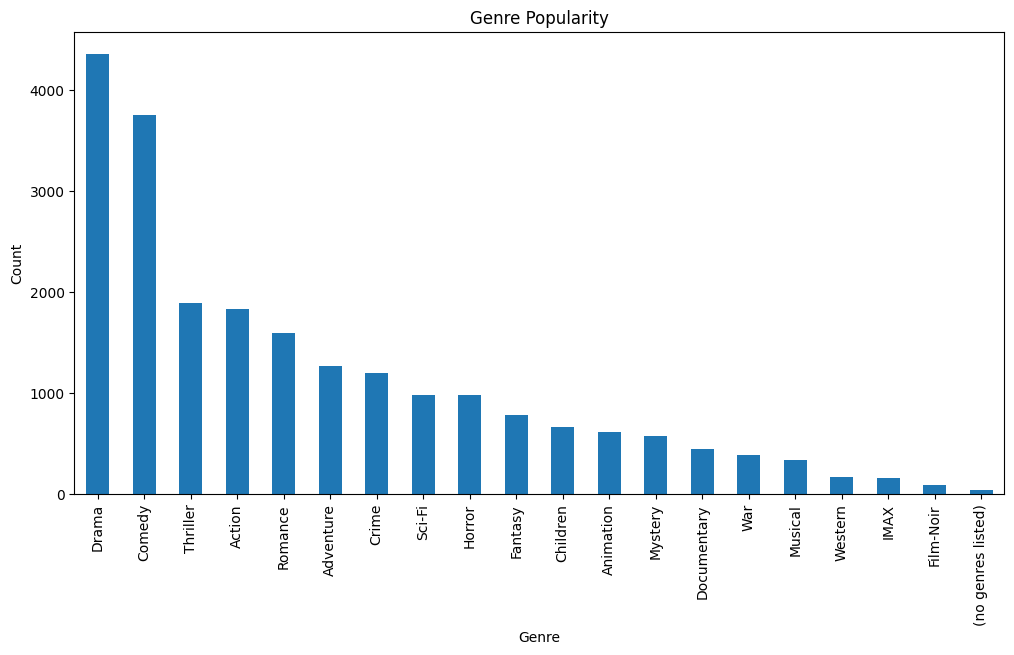

In [10]:
all_genres = [genre for sublist in movies['genres'].dropna() for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Genre Popularity')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

# **Feature Engineering**

In [11]:
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

movies_exploded = movies.explode('genres')

genre_dummies = pd.get_dummies(movies_exploded['genres']).groupby(movies_exploded['movieId']).max()

movie_features = movies[['movieId', 'year']].merge(genre_dummies, on='movieId', how='left')
movie_features.set_index('movieId', inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ratings['normalized_rating'] = scaler.fit_transform(ratings[['rating']])

# **Model Building**



* Popularity Based Recommender



In [12]:
def save_popularity_based_recommendations(n=10):
    movie_stats = ratings.groupby('movieId')['rating'].agg(['mean', 'count'])
    min_ratings = 10
    popular_movies = movie_stats[movie_stats['count'] >= min_ratings]
    popular_movies = popular_movies.sort_values(['mean', 'count'], ascending=False)
    top_movies = popular_movies.head(n).index
    top_movies_df = movies[movies['movieId'].isin(top_movies)]
    top_movies_df.to_csv('popular_movies.csv', index=False)

save_popularity_based_recommendations(n=50)

from google.colab import files
files.download('popular_movies.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
movie_features = cv.fit_transform(tags['tag'])

In [14]:
import joblib
import os
from google.colab import files

# Save models
os.makedirs('models', exist_ok=True)
joblib.dump(movie_features, 'models/movie_features.pkl')
joblib.dump(cv, 'models/count_vectorizer.pkl')

# Download
files.download('models/movie_features.pkl')
files.download('models/count_vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



* Content Based Recommender



In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(movie_id, n=10):
    similarity_matrix = cosine_similarity(movie_features)
    sim_scores = list(enumerate(similarity_matrix[movie_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices]



* Collaborative Filtering



In [16]:
!pip install scikit-surprise

In [17]:
!pip install numpy==1.24.4

In [18]:
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

user_cf = KNNBasic(sim_options={'user_based': True})
cross_validate(user_cf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

item_cf = KNNBasic(sim_options={'user_based': False})
cross_validate(item_cf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()
svd.fit(trainset)

def svd_recommendations(user_id, n=10):

    all_movie_ids = ratings['movieId'].unique()

    rated_movies = ratings[ratings['userId'] == user_id]['movieId']

    predictions = []
    for movie_id in all_movie_ids:
        if movie_id not in rated_movies:
            pred = svd.predict(user_id, movie_id)
            predictions.append((movie_id, pred.est))

    predictions.sort(key=lambda x: x[1], reverse=True)

    top_movie_ids = [x[0] for x in predictions[:n]]

    return movies[movies['movieId'].isin(top_movie_ids)]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9424  0.9418  0.9462  0.9483  0.9562  0.9470  0.0052  
MAE (testset)     0.7271  0.7230  0.7234  0.7242  0.7312  0.7258  0.0031  
Fit time          0.15    0.46    0.23    0.19    0.25    0.26    0.11    
Test time         1.82    3.96    3.53    5.07    3.03    3.48    1.07    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing s

# **Model Evaluation**

In [19]:
from surprise import Dataset
from surprise import SVD, KNNBasic
from surprise.model_selection import train_test_split
from surprise import Reader

In [20]:
import pandas as pd

ratings = pd.read_csv('ratings.csv')

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

svd = SVD()
svd.fit(trainset)

user_cf = KNNBasic(sim_options={'user_based': True})
user_cf.fit(trainset)

item_cf = KNNBasic(sim_options={'user_based': False})
item_cf.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [21]:
svd_preds = svd.test(testset)
user_cf_preds = user_cf.test(testset)
item_cf_preds = item_cf.test(testset)

In [22]:
from surprise import accuracy

svd_rmse = accuracy.rmse(svd_preds)
svd_mae = accuracy.mae(svd_preds)

print(f"SVD RMSE: {svd_rmse:.4f}")
print(f"SVD MAE: {svd_mae:.4f}")

user_cf_rmse = accuracy.rmse(user_cf_preds)
user_cf_mae = accuracy.mae(user_cf_preds)

print(f"User CF RMSE: {user_cf_rmse:.4f}")
print(f"User CF MAE: {user_cf_mae:.4f}")

item_cf_rmse = accuracy.rmse(item_cf_preds)
item_cf_mae = accuracy.mae(item_cf_preds)

print(f"Item CF RMSE: {item_cf_rmse:.4f}")
print(f"Item CF MAE: {item_cf_mae:.4f}")

RMSE: 0.8782
MAE:  0.6763
SVD RMSE: 0.8782
SVD MAE: 0.6763
RMSE: 0.9520
MAE:  0.7303
User CF RMSE: 0.9520
User CF MAE: 0.7303
RMSE: 0.9158
MAE:  0.7064
Item CF RMSE: 0.9158
Item CF MAE: 0.7064


# **Save Models**

In [23]:
import joblib
import os

In [24]:
os.makedirs('models', exist_ok=True)

In [25]:
joblib.dump(svd, 'models/svd_model.pkl')
joblib.dump(user_cf, 'models/user_cf_model.pkl')
joblib.dump(item_cf, 'models/item_cf_model.pkl')

['models/item_cf_model.pkl']

In [27]:
from google.colab import files

files.download('models/svd_model.pkl')
files.download('models/user_cf_model.pkl')
files.download('models/item_cf_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
def predict_rating(model_path, user_id, movie_id):
    model = joblib.load(model_path)
    return model.predict(user_id, movie_id).est

rating = predict_rating('models/svd_model.pkl', user_id=1, movie_id=1)
print(f"Predicted Rating: {rating:.2f}")

Predicted Rating: 4.47
